In [1]:
import sys, os
%matplotlib notebook
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
import torch
import torch.nn.functional as F
from torch.autograd import Variable, grad
import torch.distributions as distrib
import torch.nn as nn
import torch.utils.data as td
from torch.utils.data import Dataset, DataLoader
import gym
import numpy as np

import foundation as fd
import torch.multiprocessing as mp
import time
import pickle

import foundation.models.networks as nets
from foundation.lattice.core import Expansion, Node
from foundation import util

/home/fleeb/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [44]:
B = 1000
N = 1000
order = 500
T = 2 # period
r = 20

In [45]:
theta = torch.rand(B,1)*T*r-T*r/2
def saw(x):
    return x%T
def square(x):
    out = x.clone()
    x %= T
    out[x<T/2] = 1
    out[x>=T/2] = 0
    return out
def triangle(x):
    out = x.clone()
    x %= T
    sel = x<T/2
    out[sel] = x[sel]
    sel = x >= T/2
    out[sel] = T - x[sel]
    return out
target = square

In [46]:
#plt.figure()
#plt.scatter(theta.numpy()[:,0], f(theta).numpy()[:,0])

In [47]:
model = nets.Fourier_Series(order=order, period=T)
lr_decay = 10
optim = nets.get_optimizer(parameters=model.parameters(), optim_type='rmsprop', lr=1e-2, weight_decay=1e-2)
criterion = nets.get_loss_type('mse')
total_episodes = 0
periods = []

In [54]:
print_step = max(1, N//100)
stats = util.StatsMeter('loss')
for i in range(N):
    
    periods.append(model.get_period().item())
    
    X = torch.rand(B,1)*r-r/2
    Y = target(X)
    
    Y_pred = model(X)
    
    loss = criterion(Y_pred, Y)
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    stats.update('loss', loss.item())
    
    total_episodes += 1
    
    if i % print_step == 0:
        print('{}/{}: {}'.format(total_episodes, N, ', '.join(['{}={s.val:.4f}({s.avg:.4f})'.format(name, s=s) for name, s in stats.items()])))

for param_group in optim.param_groups:
    param_group['lr'] /= lr_decay
print('Learning Rate set to {}'.format(param_group['lr']))

2001/1000: loss=0.0005(0.0005)
2011/1000: loss=0.0003(0.0004)


/mnt/c/Users/anwan/OneDrive - UW/Khan/AIResearch/foundation/foundation/util/stats.py:191: RuntimeWarning: invalid value encountered in sqrt
  self.std = np.sqrt(self.var)


2021/1000: loss=0.0001(0.0004)
2031/1000: loss=0.0001(0.0003)
2041/1000: loss=0.0002(0.0003)
2051/1000: loss=0.0002(0.0003)
2061/1000: loss=0.0001(0.0003)
2071/1000: loss=0.0001(0.0003)
2081/1000: loss=0.0001(0.0003)
2091/1000: loss=0.0002(0.0003)
2101/1000: loss=0.0001(0.0003)
2111/1000: loss=0.0002(0.0003)
2121/1000: loss=0.0003(0.0003)
2131/1000: loss=0.0001(0.0003)
2141/1000: loss=0.0003(0.0003)
2151/1000: loss=0.0008(0.0003)
2161/1000: loss=0.0002(0.0003)
2171/1000: loss=0.0002(0.0003)
2181/1000: loss=0.0003(0.0003)
2191/1000: loss=0.0001(0.0003)
2201/1000: loss=0.0008(0.0003)
2211/1000: loss=0.0001(0.0003)
2221/1000: loss=0.0001(0.0003)
2231/1000: loss=0.0007(0.0003)
2241/1000: loss=0.0001(0.0003)
2251/1000: loss=0.0004(0.0003)
2261/1000: loss=0.0003(0.0003)
2271/1000: loss=0.0004(0.0003)
2281/1000: loss=0.0002(0.0003)
2291/1000: loss=0.0001(0.0003)
2301/1000: loss=0.0003(0.0003)
2311/1000: loss=0.0001(0.0003)
2321/1000: loss=0.0002(0.0003)
2331/1000: loss=0.0002(0.0003)
2341/100

In [55]:
#plt.figure()
#plt.plot(periods)
#print(model.get_period().item())

<IPython.core.display.Javascript object>


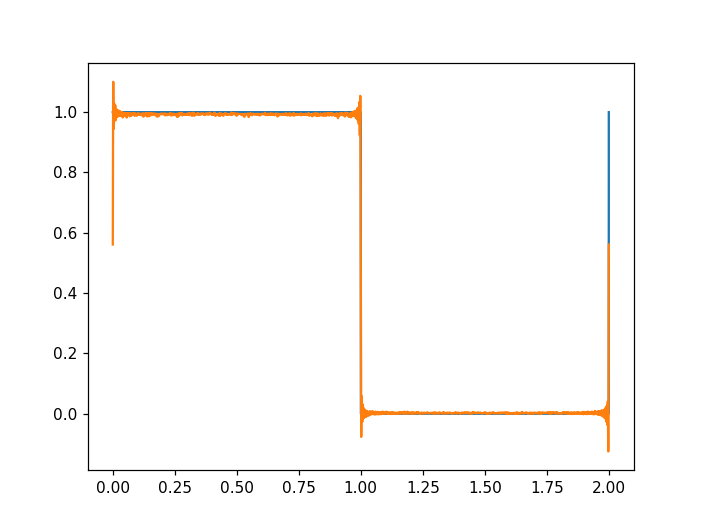

In [56]:
x = torch.linspace(0,model.get_period().item(), 10000).unsqueeze(-1)
y = target(x)
y_pred = model(x)

x = x.detach().numpy()[:,0]
y = y.detach().numpy()[:,0]
y_pred = y_pred.detach().numpy()[:,0]

plt.figure()
plt.plot(x, y)
plt.plot(x,y_pred)